In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import holidays

import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

# Data preprocessing

In [157]:
df =  pd.read_csv('2yrs_data.csv')

In [158]:
data = df.copy()
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
#data.set_index('Datetime', inplace=True)

# # Resample data to hourly frequency and compute the sum
# hourly_data = df['Global_active_power'].resample('H').sum().reset_index()
# hourly_data.rename(columns={'Global_active_power': 'Hourly_Sum'}, inplace=True)

# scaler = MinMaxScaler(feature_range=(0, 1))
# data_scaled = scaler.fit_transform(hourly_data['Hourly_Sum'].values.reshape(-1, 1))

df['Date'] = pd.to_datetime(df['Date'])
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)

fr_holidays = holidays.France(years=range(2006, 2010))
df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')
df = df.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df = df.drop(columns=['index']).drop_duplicates().reset_index(drop=True)

scaler = StandardScaler()
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])


/var/folders/hb/pn_3c51d1fj1n2jntgjrxmpm0000gn/T/ipykernel_5745/128374963.py:16: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)


In [159]:
df

,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power
0,1,0,17,16,12,2006,1.473913
1,1,0,18,16,12,2006,2.611597
2,1,0,19,16,12,2006,2.371349
3,1,0,20,16,12,2006,2.234981
4,1,0,21,16,12,2006,2.015309
...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,2.115323
17845,0,0,20,31,12,2008,3.177884
17846,0,0,21,31,12,2008,0.947328
17847,0,0,22,31,12,2008,-0.066589


In [160]:
df['hourly_active_power'].describe()

count    1.784900e+04
mean    -5.413962e-17
std      1.000028e+00
min     -1.078503e+00
25%     -8.280364e-01
50%     -3.405663e-01
75%      5.342907e-01
max      5.644476e+00
Name: hourly_active_power, dtype: float64

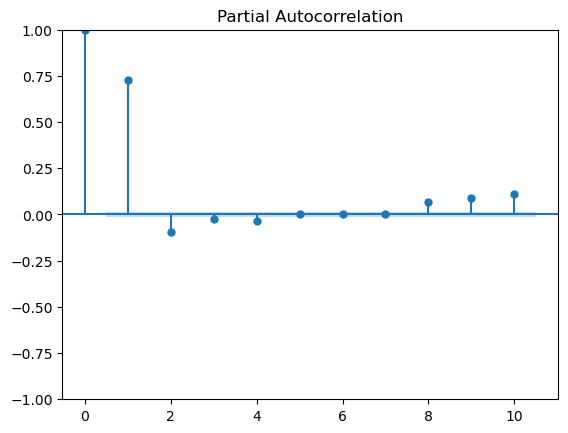

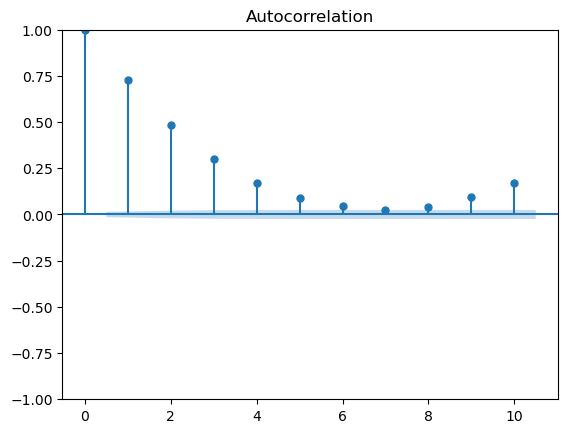

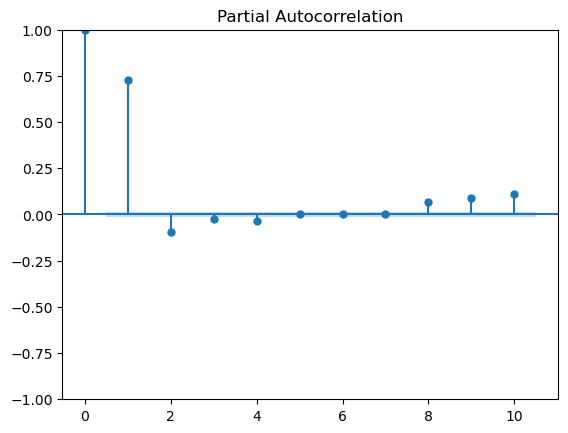

In [161]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['hourly_active_power'], lags=10)
plot_pacf(df['hourly_active_power'], lags=10)

# Baseline

In [ ]:
# Parameters
N_STEPS_IN = 2
N_STEPS_OUT = 5
N_EPOCHS = 20
BATCH_SIZE = 16

train_size = int(len(df) * 0.8)  # 80% for training
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Function to create sequences
def create_sequences(data, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(data) - n_steps_in - n_steps_out + 1):
        X.append(data[i:i + n_steps_in])
        y.append(data[i + n_steps_in:i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)

# Prepare sequences for training
train_values = train['hourly_active_power'].values  # Get values as a NumPy array
X_train, y_train = create_sequences(train_values, N_STEPS_IN, N_STEPS_OUT)

test_values = test['hourly_active_power'].values
X_test, y_test = create_sequences(test_values, N_STEPS_IN, N_STEPS_OUT)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))  # 1 feature
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14270, 5, 1)
y_train shape: (14270, 5)
X_test shape: (3561, 5, 1)
y_test shape: (3561, 5)


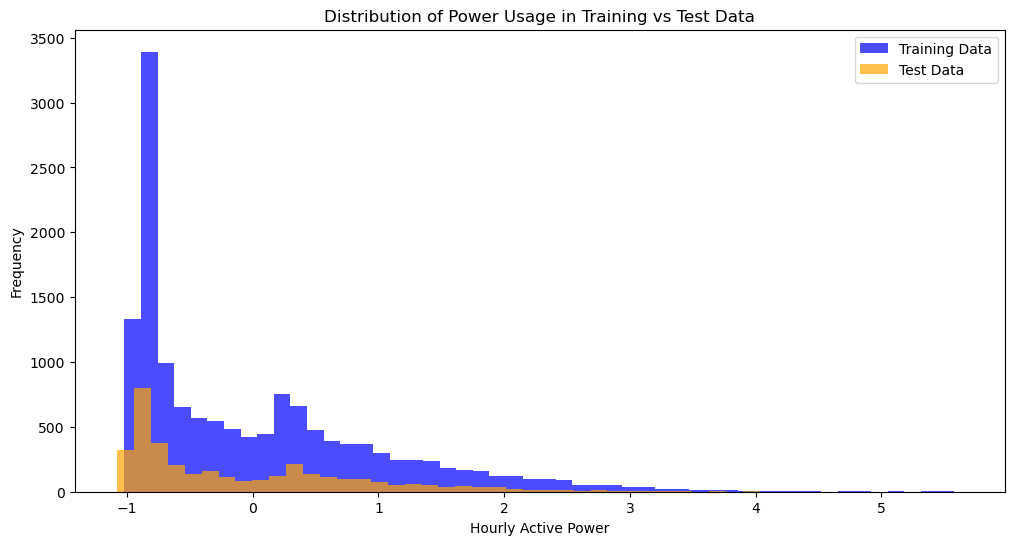

In [163]:
plt.figure(figsize=(12, 6))
plt.hist(train['hourly_active_power'], bins=50, alpha=0.7, label='Training Data', color='blue')
plt.hist(test['hourly_active_power'], bins=50, alpha=0.7, label='Test Data', color='orange')
plt.title('Distribution of Power Usage in Training vs Test Data')
plt.xlabel('Hourly Active Power')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, 1)),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dropout(0.1),
    Dense(N_STEPS_OUT)
])

# Compile model
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Remove validation references in callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    shuffle=False
)

# Predict on the test set
test_predictions = model.predict(X_test, verbose=0)

# Reshape predictions and labels for comparison
test_predictions = np.squeeze(test_predictions)  # Ensure 1D if necessary
y_test = np.squeeze(y_test)  # Ensure 1D if necessary

# Ensure the shapes are consistent
print(f"Shape of predictions: {test_predictions.shape}")
print(f"Shape of test labels: {y_test.shape}")

# Calculate metrics
test_mse = mean_squared_error(y_test, test_predictions)
mape = np.mean(np.abs((y_test - test_predictions) / (y_test + 1e-6))) * 100  # Avoid division-by-zero
r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

# Print metrics
print(f"Test MSE: {test_mse:.5f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.5f}")
print(f"Test RMSE: {test_rmse:.5f}")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: No gradients provided for any variable.

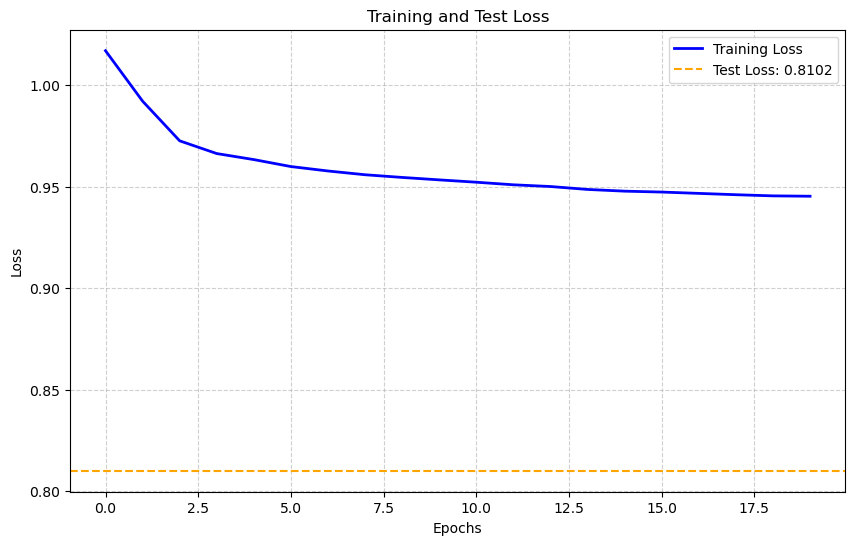

In [ ]:
loss = history.history['loss']
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Plot training loss and test loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

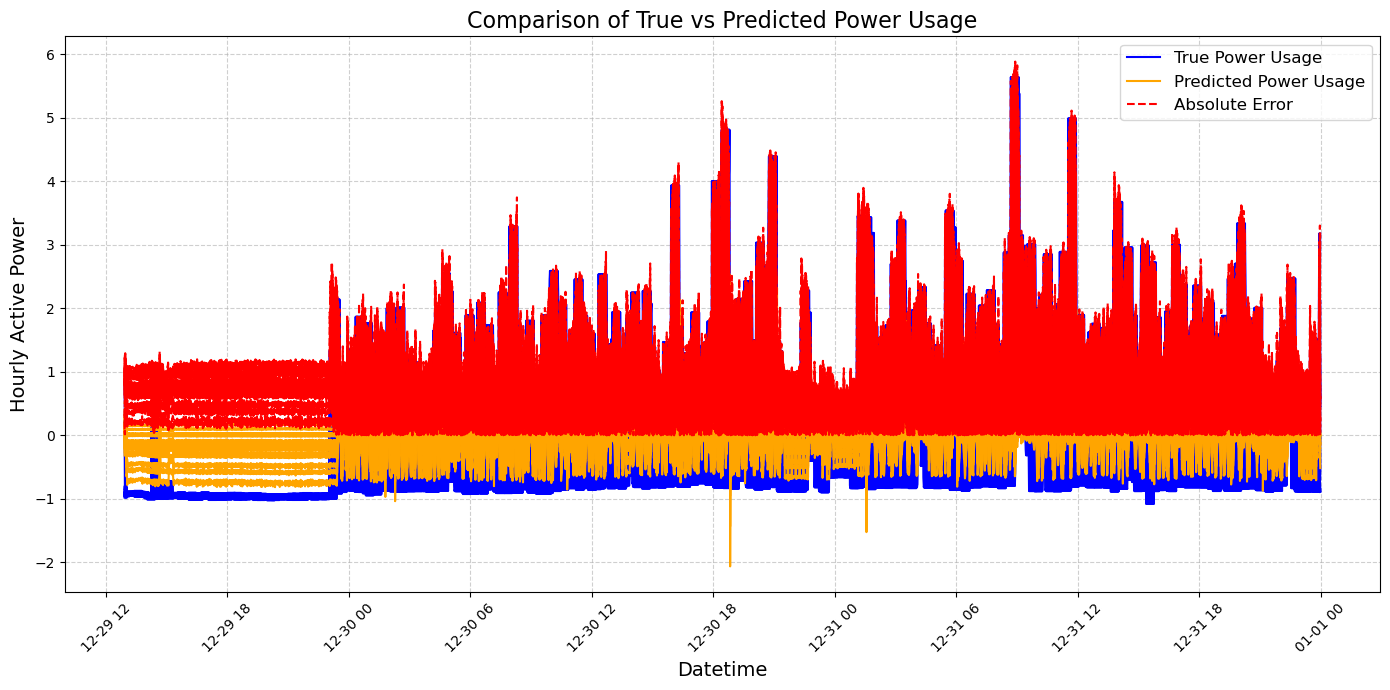

In [ ]:
# Predict on the test set
y_pred_test = model.predict(X_test, verbose=0).squeeze()  # Ensure predictions are 1D

absolute_error = np.abs(y_test.squeeze() - y_pred_test)
datetime_test = data['Datetime'][-len(y_test):]
plt.figure(figsize=(14, 7))
plt.plot(datetime_test, y_test.squeeze(), label='True Power Usage', color='blue', linewidth=1.5)
plt.plot(datetime_test, y_pred_test, label='Predicted Power Usage', color='orange', linewidth=1.5)
plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1.5)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()  # Get current handles and labels
by_label = dict(zip(labels, handles))  # Use a dictionary to remove duplicates
plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper right')  # Add legend with unique entries

# Add labels, title, and grid
plt.title('Comparison of True vs Predicted Power Usage', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Min prediction: {y_pred_test.min()}")
print(f"Max prediction: {y_pred_test.max()}")
print(f"Mean prediction: {y_pred_test.mean()}")

Min prediction: -1.5390551090240479
Max prediction: 1.7756160497665405
Mean prediction: -0.13936135172843933


	1.	Training and Test Data Distribution:
	•	The training data shows a high frequency of values near -1.
	•	The test data distribution is smaller in frequency and possibly differs slightly.
	2.	Prediction Statistics:
	•	The minimum prediction is approximately -1.14, close to the most frequent value in the training data.
	•	The mean prediction is -0.15, indicating that the model may be averaging out predictions rather than capturing dynamic patterns.
	•	The maximum prediction is 1.7, suggesting the model is struggling to predict the high values in the test set.

# Added Features

In [ ]:

# Select features and target
features = ['is_weekend', 'is_holiday', 'hourly_active_power']
target = 'hourly_active_power'

# Create sequences
X_train, y_train = create_sequences(train[features], target, N_STEPS_IN, N_STEPS_OUT)
X_test, y_test = create_sequences(test[features], target, N_STEPS_IN, N_STEPS_OUT)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14270, 5, 3)
y_train shape: (14270, 5)
X_test shape: (3561, 5, 3)
y_test shape: (3561, 5)


# Model fitting and training

In [ ]:
# Update the input shape to include multiple features
num_features = X_train.shape[2]  # Get the number of features from the input data

model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, num_features)),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dropout(0.1),
    Dense(N_STEPS_OUT)
])

# Compile model
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)  # Clip gradients
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Remove validation references in callbacks
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping, reduce_lr],
    shuffle=False
)

# Predict on the test set
test_predictions = model.predict(X_test, verbose=0)

# Reshape predictions and labels for comparison
test_predictions = np.squeeze(test_predictions)  # Ensure 1D if necessary
y_test = np.squeeze(y_test)  # Ensure 1D if necessary

# Ensure the shapes are consistent
print(f"Shape of predictions: {test_predictions.shape}")
print(f"Shape of test labels: {y_test.shape}")

# Calculate metrics
test_mse = mean_squared_error(y_test, test_predictions)
mape = np.mean(np.abs((y_test - test_predictions) / (y_test + 1e-6))) * 100  # Avoid division-by-zero
r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)

# Print metrics
print(f"Test MSE: {test_mse:.5f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.5f}")
print(f"Test RMSE: {test_rmse:.5f}")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


892/892 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2220 - mae: 0.8820 - learning_rate: 1.0000e-04
Epoch 2/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1338 - mae: 0.8415 - learning_rate: 1.0000e-04
Epoch 3/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0694 - mae: 0.8061 - learning_rate: 1.0000e-04
Epoch 4/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0439 - mae: 0.7914 - learning_rate: 1.0000e-04
Epoch 5/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0252 - mae: 0.7804 - learning_rate: 1.0000e-04
Epoch 6/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0130 - mae: 0.7734 - learning_rate: 1.0000e-04
Epoch 7/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0018 - mae: 0.7672 - learning_rate: 1.0000e-04
Epoch 8/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9925 - mae: 0.7621 - learning_rate: 1.0000e-04
Epoch 9/20
892/892 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9878 - mae: 0.7585 - learning_rate: 1.0000e-04
Epoch 10/20
892/892 ━━━━━━━━━━

# Graphs and Results

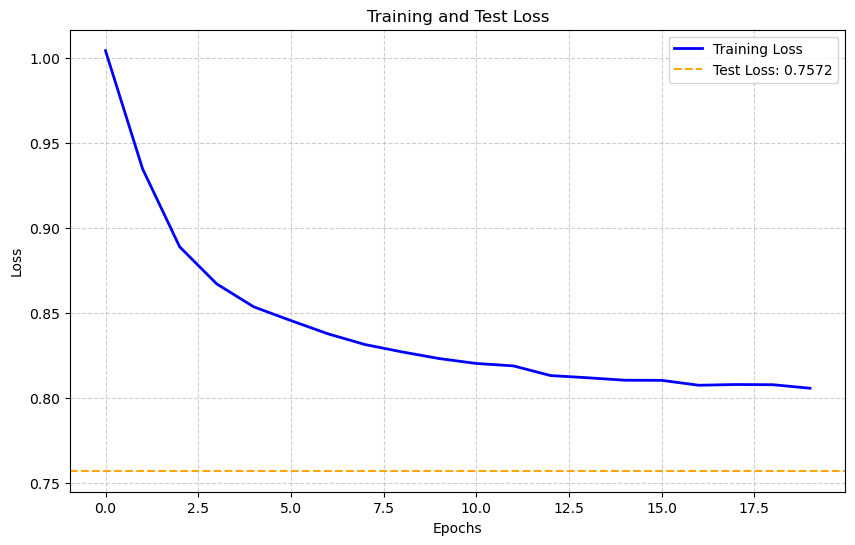

In [ ]:
loss = history.history['loss']
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Plot training loss and test loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss', color='blue', linewidth=2)
plt.axhline(y=test_loss, color='orange', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

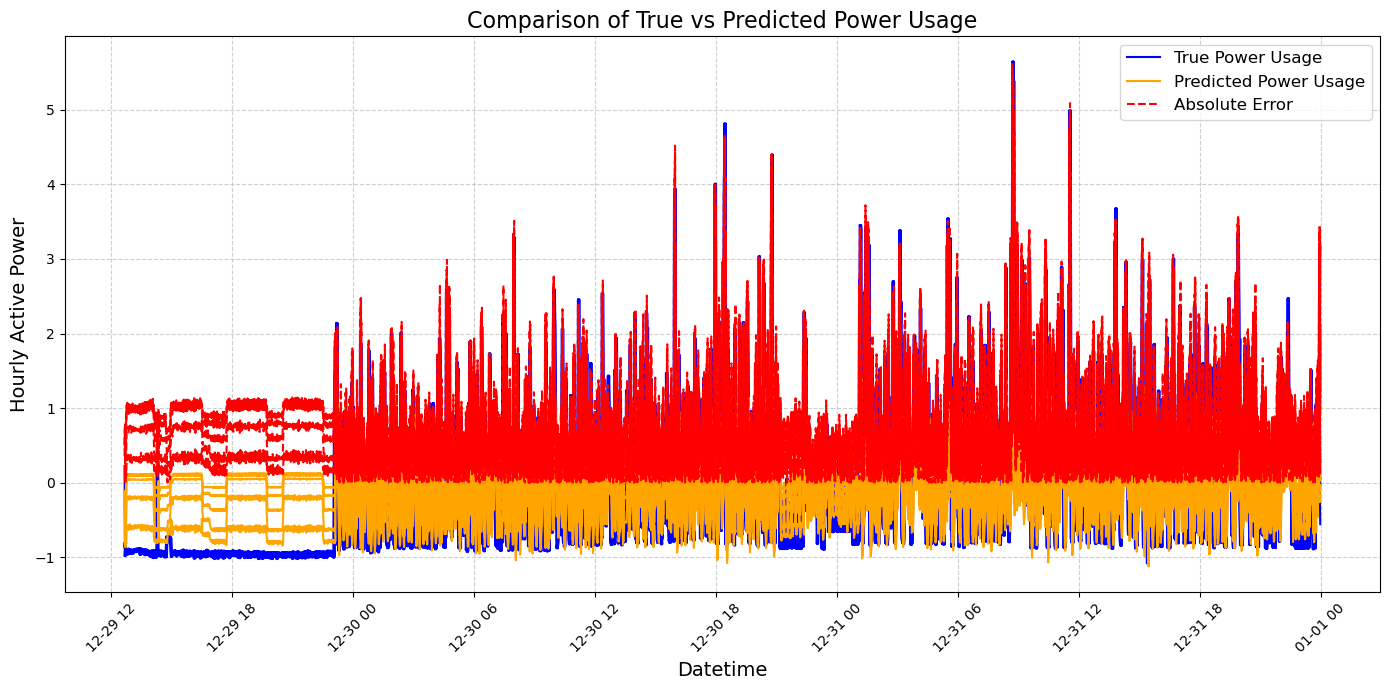

In [ ]:
# Predict on the test set
y_pred_test = model.predict(X_test, verbose=0).squeeze()  # Ensure predictions are 1D

# Calculate absolute error
absolute_error = np.abs(y_test.squeeze() - y_pred_test)

# Extract datetime for test data
datetime_test = data['Datetime'][-len(y_test):]

# Create the plot
plt.figure(figsize=(14, 7))

# Plot true values
plt.plot(datetime_test, y_test.squeeze(), label='True Power Usage', color='blue', linewidth=1.5)

# Plot predictions
plt.plot(datetime_test, y_pred_test, label='Predicted Power Usage', color='orange', linewidth=1.5)

# Plot absolute error
plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1.5)

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()  # Get current handles and labels
by_label = dict(zip(labels, handles))  # Use a dictionary to remove duplicates
plt.legend(by_label.values(), by_label.keys(), fontsize=12, loc='upper right')  # Add legend with unique entries

# Add labels, title, and grid
plt.title('Comparison of True vs Predicted Power Usage', fontsize=16)
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('Hourly Active Power', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
print(f"Min prediction: {y_pred_test.min()}")
print(f"Max prediction: {y_pred_test.max()}")
print(f"Mean prediction: {y_pred_test.mean()}")

Min prediction: -1.1204733848571777
Max prediction: 1.863279104232788
Mean prediction: -0.14274193346500397


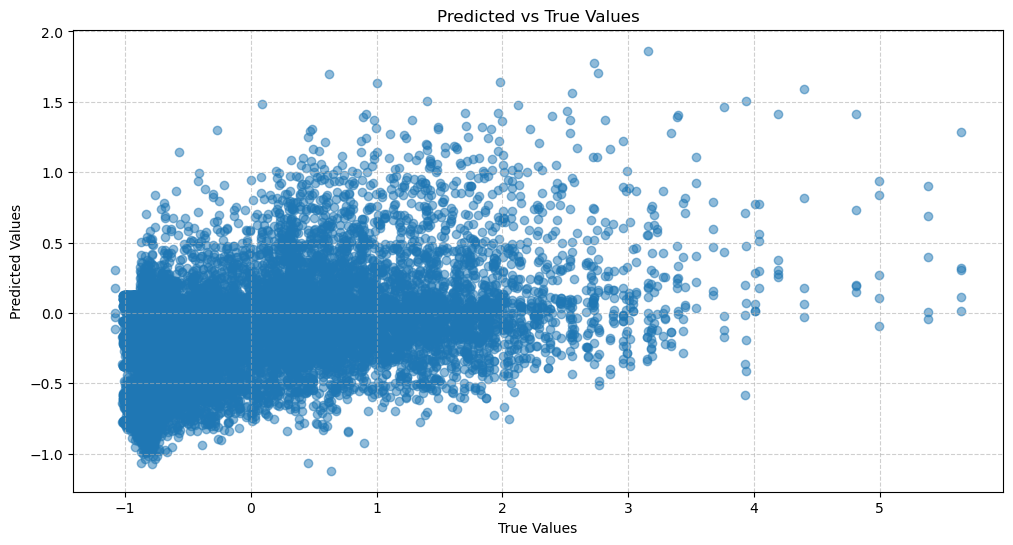

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# Ensure 'Date' is a datetime object
data['Date'] = pd.to_datetime(data['Date'])

# Extract day and month for grouping
data['Day'] = data['Date'].dt.day
data['MonthYear'] = data['Date'].dt.to_period('M')  # Year-Month grouping

# Iterate through each unique Month-Year and plot
for month_year in data['MonthYear'].unique():
    # Subset the data for the current Month-Year
    monthly_data = data[data['MonthYear'] == month_year]

    # Create the box plot for each day of the month
    plt.figure(figsize=(12, 6))
    monthly_data.boxplot(column=PREDICTION_TERM, by='Day', grid=False, showfliers=False)
    plt.title(f'Box Plot for {month_year}')
    plt.suptitle('')  # Removes default subtitle
    plt.xlabel('Day of the Month')
    plt.ylabel('Values')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

NameError: name 'PREDICTION_TERM' is not defined

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Save model
model.save('lstm_model.h5')

# # Load model
# from tensorflow.keras.models import load_model
# model = load_model('/kaggle/working/lstm_model.h5')